## 1️⃣ 문제 정의

전복의 나이는 껍데기를 원뿔 모양으로 잘라 염색한 후 현미경으로 나이테 수를 세는 방식으로 판별하는데, 이는 지루하고 시간이 많이 걸리는 작업입니다. 따라서 더 쉽게 얻을 수 있는 다른 측정값을 이용하여 나이를 예측하기도 합니다. 또한, 날씨 패턴이나 서식지(먹이 가용성)와 같은 추가 정보가 필요한 경우도 있습니다.

원본 데이터 세트

## 2️⃣ 데이터 로드

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

import shap
shap.initjs()

data = pd.read_csv("./abalone.csv")
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Text(0.5, 0, 'Whole weight')

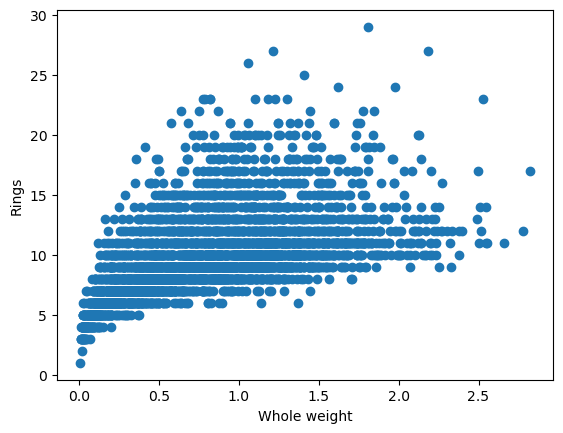

In [3]:
plt.scatter(data["Whole weight"], data["Rings"])
plt.ylabel("Rings", size=10)
plt.xlabel("Whole weight", size=10)

Text(0.5, 0, 'Sex')

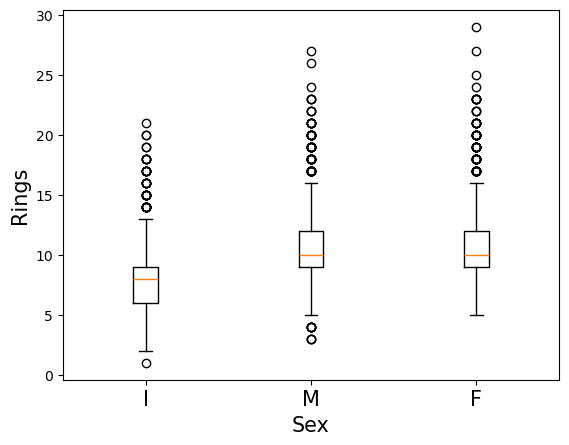

In [4]:
plt.boxplot(data[data.Sex=="I"]["Rings"], positions=[1])
plt.boxplot(data[data.Sex=="M"]["Rings"], positions=[2])
plt.boxplot(data[data.Sex=="F"]["Rings"], positions=[3])

plt.xticks(ticks=[1, 2, 3], labels=["I", "M", "F"], size=15)
plt.ylabel("Rings", size=15)
plt.xlabel("Sex", size=15)

<Axes: >

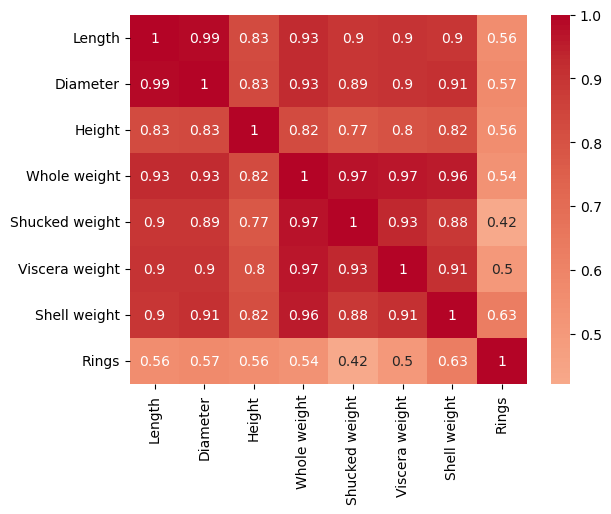

In [5]:
num_cols = [col for col in data.columns if data[col].dtype != "object"]
corr_matrix = pd.DataFrame(data[num_cols], columns=num_cols).corr()

sns.heatmap(corr_matrix,
           cmap="coolwarm",
           center=0,
           annot=True,
           fmt=".2g")

## 3️⃣ 타깃 변수 변환 (Label Encoding)

In [6]:
data["Sex"] = data["Sex"].astype('category')

In [7]:
def split(df_train):
    y = df_train["Rings"]
    X = df_train.drop(["Rings"], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    return X_train, y_train, X_test, y_test

In [8]:
X_train, y_train, X_test, y_test = split(data)

## 4️⃣ 학습 / 테스트 데이터 분리

In [9]:
model = xgb.XGBRegressor(
    enable_categorical=True,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


## 5️⃣ 범주형 변수 처리 (One-Hot Encoding)

Text(0.5, 0, 'Actual')

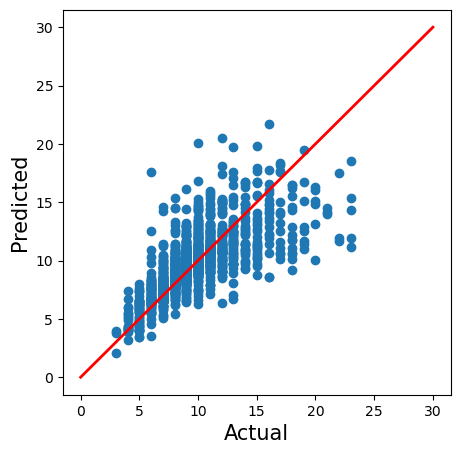

In [10]:
predicts = model.predict(X_test)

plt.figure(figsize=(5, 5))

plt.scatter(y_test, predicts)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel("Predicted", size=15)
plt.xlabel("Actual", size=15)

## 6️⃣ Standard SHAP values

In [12]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

np.shape(shap_values.values)

(1254, 8)

## 7️⃣ Waterfall Plot


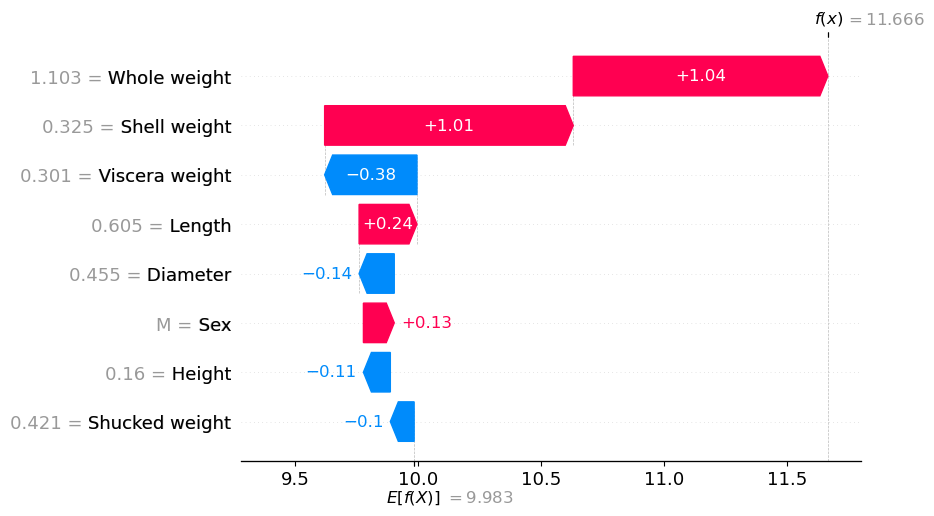

In [13]:
shap.plots.waterfall(shap_values[0])


In [14]:
shap.plots.force(shap_values[0])

In [15]:
shap.plots.force(shap_values[0:100])

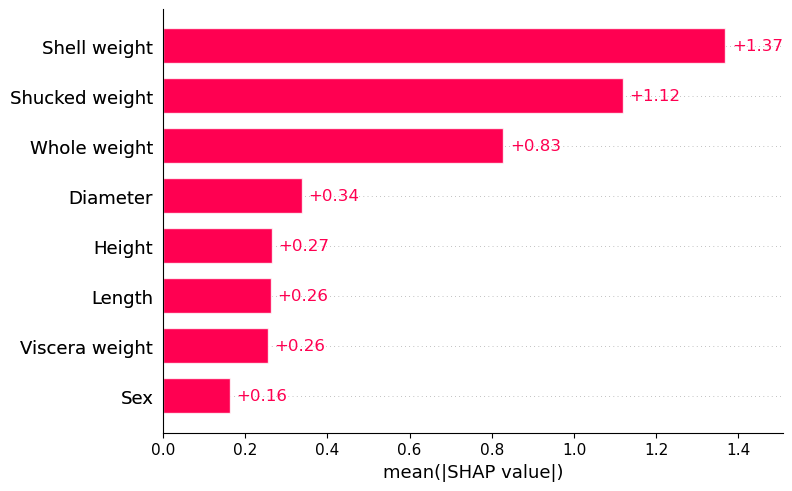

In [16]:
shap.plots.bar(shap_values)

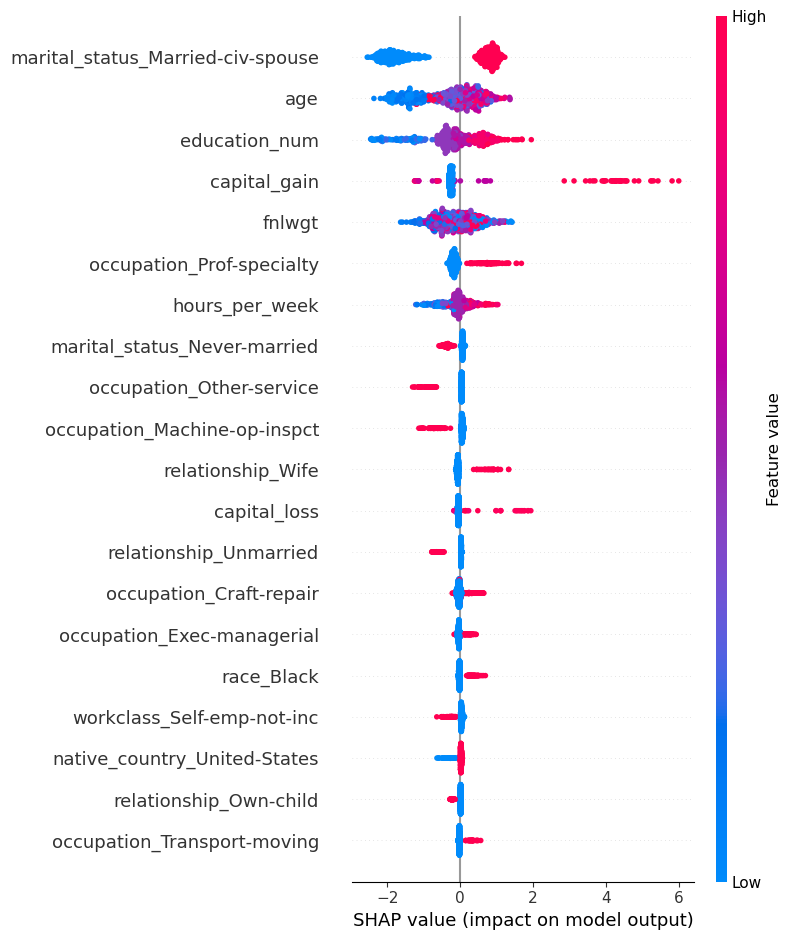

In [16]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

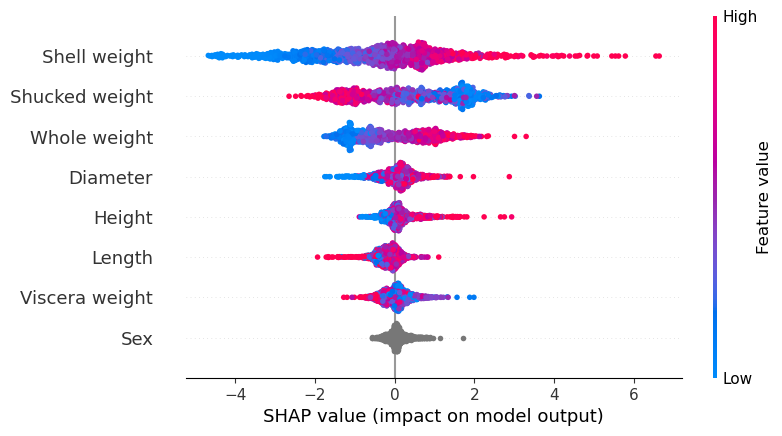

In [17]:
shap.plots.beeswarm(shap_values)

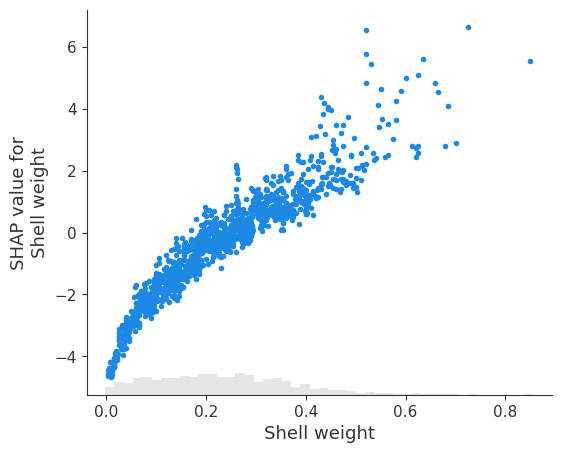

In [18]:
shap.plots.scatter(shap_values[:, "Shell weight"])

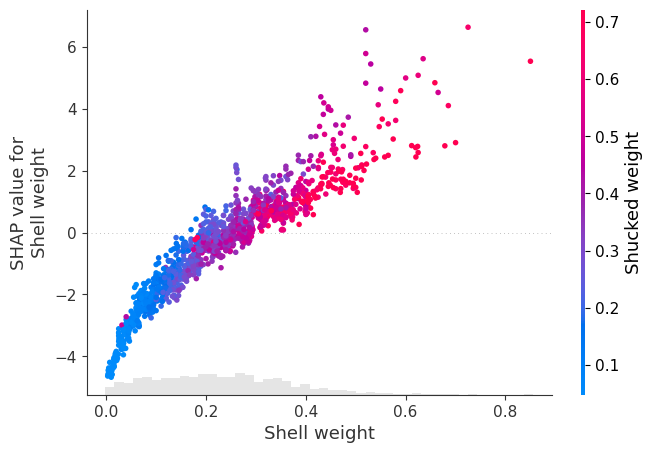

In [19]:
shap.plots.scatter(shap_values[:, "Shell weight"],
                  color=shap_values[:, "Shucked weight"])

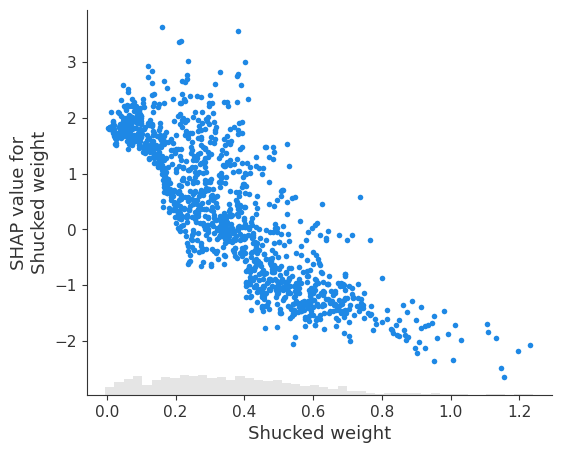

In [21]:
shap.plots.scatter(shap_values[:, "Shucked weight"])

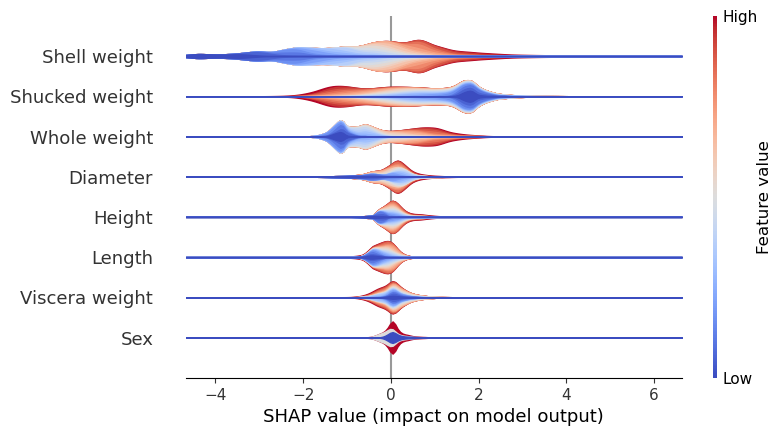

In [22]:
shap.plots.violin(shap_values, plot_type="layered_violin")

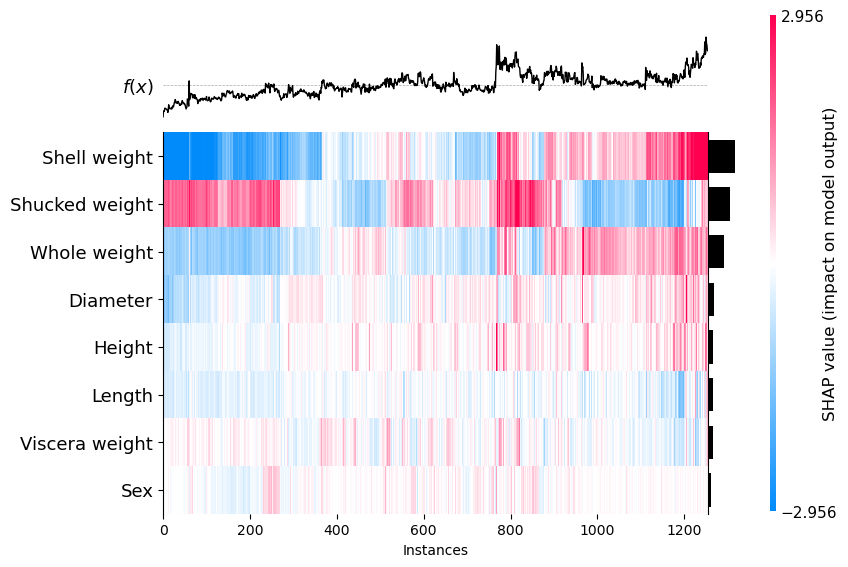

<Axes: xlabel='Instances'>

In [23]:
shap.plots.heatmap(shap_values)

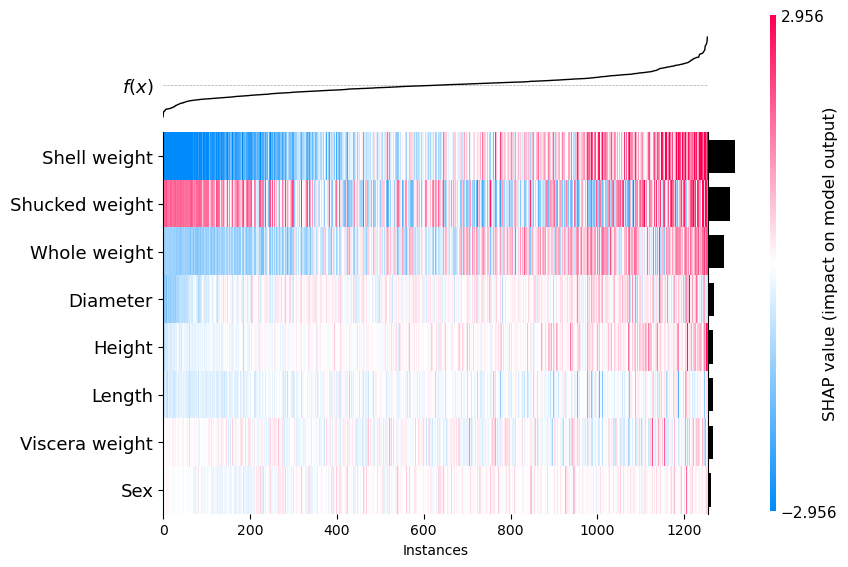

<Axes: xlabel='Instances'>

In [24]:
order = np.argsort(predicts)
shap.plots.heatmap(shap_values, instance_order=order)